In [10]:
import dat
import csv
import pandas as pd
# GloVe model from https://nlp.stanford.edu/projects/glove/
model = dat.Model("../glove.840B.300d.txt", "words.txt")
datapath = '../data/'

#load DAT Olson's data
filename = "study2.tsv"
dat_list = []

with open(filename, "r") as file:
    reader = csv.DictReader(file, delimiter="\t")
    for row in reader:
        dat_list.append(row["dat"])
dat_list = [float(x) for x in dat_list]
print(len(dat_list))

#load DAT big data file
global_crea = pd.read_csv('./global-creativity.csv')
DAT_bigdata = global_crea['score']

8572


In [15]:
import json
import fnmatch
import os
import glob
DAT_GPT = []
DAT_GPT_thes = []
DAT_GPT_rnd = []
DAT_GPT_opp = []
DAT_GPT_etym = []
GPT_raw = []

DAT_GPT4 = []
GPT4_etym = []
GPT4_opp = []
GPT4_thes = []
GPT4_hightemp = []
GPT4_lowtemp = []
GPT4_control_hightemp = []
GPT4_control_lowtemp = []
GPT4_raw = []

# Define the filename patterns and the corresponding lists
filename_patterns = {
    'sample_thes*': DAT_GPT_thes,
    'sample_rand*': DAT_GPT_rnd,
    'sample_oppo*': DAT_GPT_opp,
    'sample_ety*': DAT_GPT_etym,
    'sample_none*': DAT_GPT,
    'sample_nothing*': GPT_raw,
    'gpt4_none*': DAT_GPT4,
    'gpt4_nothing*': GPT4_raw,
    'gpt4_ety*': GPT4_etym,
    'gpt4_oppo*': GPT4_opp,
    'gpt4_thes*': GPT4_thes,
    'gpt4_temp1.5_none*': GPT4_hightemp,
    'gpt4_temp0.5_none*': GPT4_lowtemp,
    'gpt4_temp1.5_nothing*': GPT4_control_hightemp,
    'gpt4_temp0.5_nothing*': GPT4_control_lowtemp
}

# Get a list of filenames in the data directory
datapath = '../data/'
filenames = glob.glob(datapath)

# Loop over the files and extract the data
for filename in filenames:
    print(filenames)
    with open(filename) as f:
        data = json.load(f)
        for sample_idx in data.keys():
            # Split the words into a list and extract every other word
            words = data[sample_idx].split()
            words = [words[index] for index in range(1, len(words), 2)]
            
            # Match the filename against each pattern in the dictionary
            for pattern, data_list in filename_patterns.items():
                if fnmatch.fnmatch(filename, pattern):
                    data_list.append(model.dat(words))


IsADirectoryError: [Errno 21] Is a directory: '../data/'

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\2753546458.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(random.sample(DAT_GPT, 500), label='GPT 3.5 - DAT', color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\2753546458.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.dist

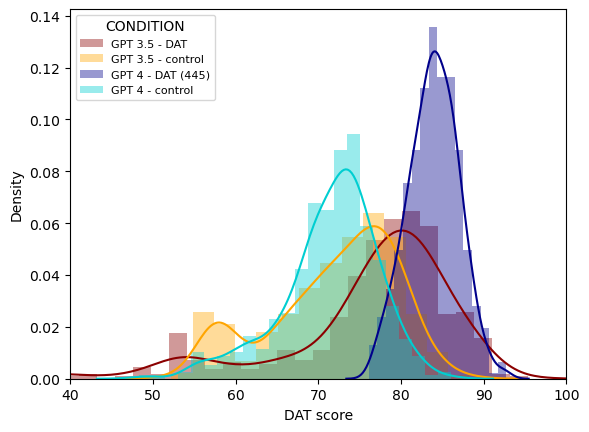

In [7]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import random

#print(np.mean(DAT_GPT))
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(random.sample(DAT_GPT, 500), label='GPT 3.5 - DAT', color='darkred')
sbn.distplot(random.sample(GPT_raw, 500), label='GPT 3.5 - control', color='orange')
sbn.distplot(DAT_GPT4, label='GPT 4 - DAT ({})'.format(len(DAT_GPT4)), color='darkblue')
sbn.distplot(random.sample(GPT4_raw, 500), label='GPT 4 - control', color='darkturquoise')

mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#lt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')
plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'CONDITION', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT_control5.png', dpi=300)

In [10]:
len(GPT4_hightemp)

309

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\4192106586.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(GPT4_lowtemp, label='0.5 (n={})'.format(str(len(GPT4_lowtemp))), color='darkcyan')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\4192106586.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

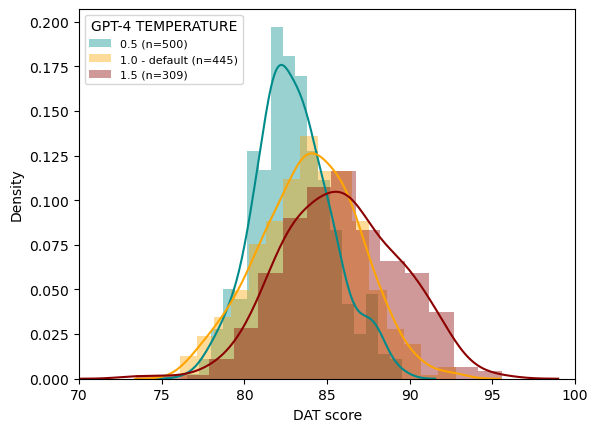

In [17]:
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(GPT4_lowtemp, label='0.5 (n={})'.format(str(len(GPT4_lowtemp))), color='darkcyan')
sbn.distplot(DAT_GPT4, label='1.0 - default (n={})'.format(str(len(DAT_GPT4))), color='orange')
sbn.distplot(GPT4_hightemp, label='1.5 (n={})'.format(str(len(GPT4_hightemp))), color='darkred')

mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#lt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')
plt.xlim((70, 100))
plt.xlabel('DAT score')
plt.legend(title = 'GPT-4 TEMPERATURE', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT4_temp.png', dpi=300)

In [47]:
np.mean(DAT_GPT4)

83.91917049686947

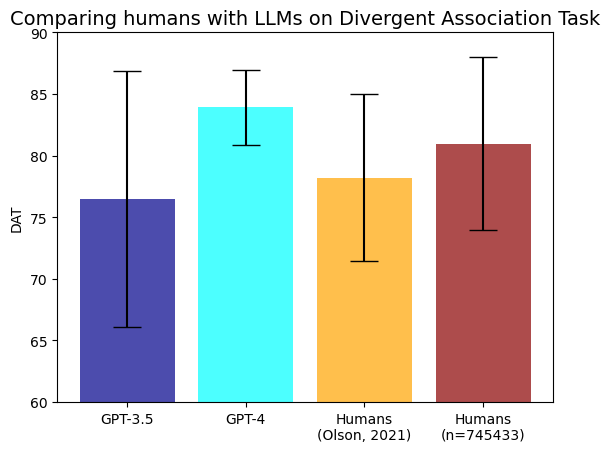

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def create_bar_plot(distributions, labels=None, colors=None, save=False, title=None, ylim=(60, 90)):
    if title is None:
        title = 'Mean and Standard Deviation of Multiple Distributions'
    
    # Calculate means and standard deviations for each distribution
    means = [np.mean(dist) for dist in distributions]
    std_devs = [np.std(dist) for dist in distributions]

    # Set up the bar plot
    x_labels = labels if labels else [f'Dist {i+1}' for i in range(len(distributions))]
    x_pos = np.arange(len(distributions))

    # Create the bars with a color palette
    colors = colors if colors else plt.cm.tab10(np.linspace(0, 1, len(distributions)))
    fig, ax = plt.subplots()
    bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10, color=colors)

    # Set labels and ticks
    ax.set_ylabel('DAT')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    plt.ylim(ylim)
    ax.set_title(title, fontsize=14)

    # Function to draw curly brackets
    def draw_curly_bracket(ax, x_start, x_end, y, height, color='black', lw=1):
        center_x = (x_start + x_end) / 2
        ax.plot([x_start, x_start, center_x, x_end, x_end], [y, y + height, y + height * 1.5, y + height, y], color=color, lw=lw)

    # Perform independent t-tests and annotate the plot
    '''for i in range(len(distributions)):
        for j in range(i + 1, len(distributions)):
            t_stat, p_value = ttest_ind(distributions[i], distributions[j])
            significance = ''
            if p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            if significance:
                y_pos = max(means[i] + std_devs[i], means[j] + std_devs[j])
                bracket_height = 0.1 * y_pos
                draw_curly_bracket(ax, x_pos[i], x_pos[j], y_pos, bracket_height)
                ax.annotate(significance, ((x_pos[i] + x_pos[j]) / 2, y_pos + bracket_height * 2), ha='center', va='bottom', fontsize=12)'''

    if save is True:
        plt.savefig(title+'.png', dpi=300)

    # Show the bar plot
    plt.show()



'''GPT4_raw = [x for x in GPT4_raw if str(x) != 'None']
GPT_raw = [x for x in GPT_raw if str(x) != 'None']
create_bar_plot([DAT_GPT, GPT_raw, DAT_GPT4, GPT4_raw], labels=['GPT-3.5 (DAT)', 'GPT-3.5 (control)', 'GPT-4 (DAT)', 'GPT-4 (control)'],
                colors=['darkblue', 'turquoise', 'darkred', 'pink'], save=True, title='Effect of GPT version on Divergent Association Task', ylim=(60, 90))'''


'''GPT4_hightemp = [x for x in GPT4_hightemp if str(x) != 'None']
GPT4_lowtemp = [x for x in GPT4_lowtemp if str(x) != 'None']
create_bar_plot([GPT4_lowtemp, DAT_GPT4, GPT4_hightemp], labels=['Low temp (0.5)', 'Mid temp (1.0)', 'High temp (1.5)'],
                colors=['darkblue', 'orange', 'darkred'], save=True, title='Effect of temperature levels of GPT-4 on Divergent Association', ylim=(80, 90))'''


'''GPT4_hightemp = [x for x in GPT4_hightemp if str(x) != 'None']
GPT4_lowtemp = [x for x in GPT4_lowtemp if str(x) != 'None']
create_bar_plot([GPT4_lowtemp, GPT4_control_lowtemp, DAT_GPT4, GPT4_raw, GPT4_hightemp, GPT4_control_hightemp],
                labels=['0.5', '0.5 - control', '1.0', '1.0 - control', '1.5', '1.5 - control'],
                colors=['darkblue', 'cyan', 'orange', 'yellow', 'darkred', 'pink'], save=True, title='Effect of temperature levels of GPT-4 on Divergent Association',
                ylim=(60, 90))'''

create_bar_plot([DAT_GPT, DAT_GPT4, dat_list, DAT_bigdata],
                labels=['GPT-3.5', 'GPT-4', 'Humans\n(Olson, 2021)', 'Humans\n(n={})'.format(len(DAT_bigdata))],
                colors=['darkblue', 'cyan', 'orange', 'darkred', 'darkred', 'pink'], save=True, title='Comparing humans with LLMs on Divergent Association Task',
                ylim=(60, 90))

In [22]:
from scipy import stats

DAT_GPT4 = [x for x in DAT_GPT4 if str(x) != 'None']
GPT4_hightemp = [x for x in GPT4_hightemp if str(x) != 'None']
GPT4_lowtemp = [x for x in GPT4_lowtemp if str(x) != 'None']
stats.ttest_ind(DAT_GPT4, GPT4_lowtemp)

Ttest_indResult(statistic=5.613940644394734, pvalue=2.600664439021074e-08)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\1253239484.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(GPT4_control_lowtemp, label='0.5', color='darkcyan')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\1253239484.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(random.sample

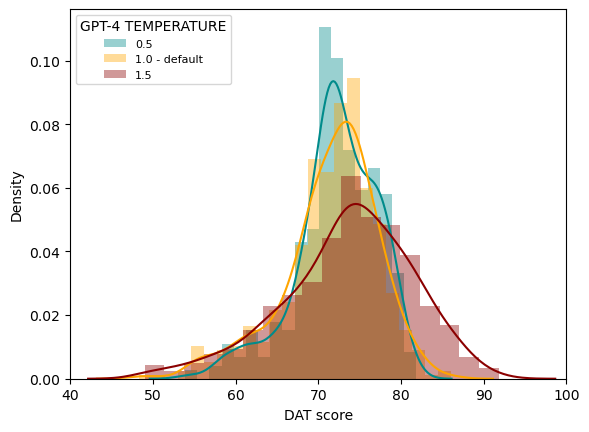

In [31]:
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(GPT4_control_lowtemp, label='0.5', color='darkcyan')
sbn.distplot(random.sample(GPT4_raw, 500), label='1.0 - default', color='orange')
sbn.distplot(GPT4_control_hightemp, label='1.5', color='darkred')

mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#lt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')
plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'GPT-4 TEMPERATURE', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT4_temp_control-n500.png', dpi=300)

In [33]:
from scipy import stats

GPT4_raw = [x for x in GPT4_raw if str(x) != 'None']
GPT4_control_hightemp = [x for x in GPT4_control_hightemp if str(x) != 'None']
GPT4_control_lowtemp = [x for x in GPT4_control_lowtemp if str(x) != 'None']
stats.ttest_ind(GPT4_raw, GPT4_control_hightemp)

Ttest_indResult(statistic=-4.763250029005738, pvalue=2.1873710739569325e-06)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_8348\2483540186.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(DAT_GPT, label='GPT-3.5({})'.format(len(DAT_GPT)), color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_8348\2483540186.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplo

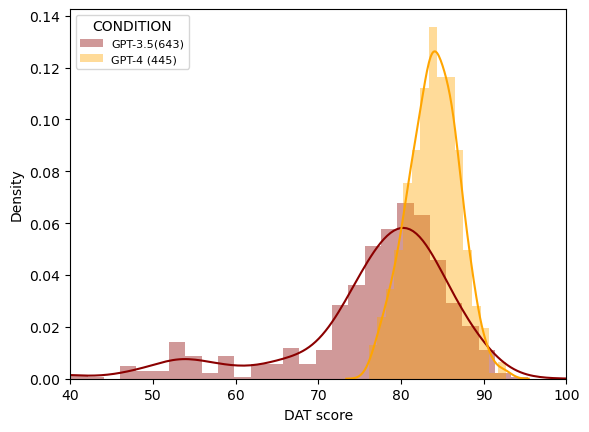

In [12]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
#print(np.mean(DAT_GPT))
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(DAT_GPT, label='GPT-3.5({})'.format(len(DAT_GPT)), color='darkred')
sbn.distplot(DAT_GPT4, label='GPT-4 ({})'.format(len(DAT_GPT4)), color='orange')


mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#lt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')
plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'CONDITION', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT3-4_vanilla.png', dpi=300)

In [16]:
from scipy import stats

GPT_raw = [x for x in GPT_raw if str(x) != 'None']
stats.ttest_ind(GPT_raw, DAT_GPT)

Ttest_indResult(statistic=-9.28174714710758, pvalue=5.316970876545369e-20)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_8348\4212925813.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(DAT_GPT, label='GPT-3.5({})'.format(len(DAT_GPT)), color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_8348\4212925813.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplo

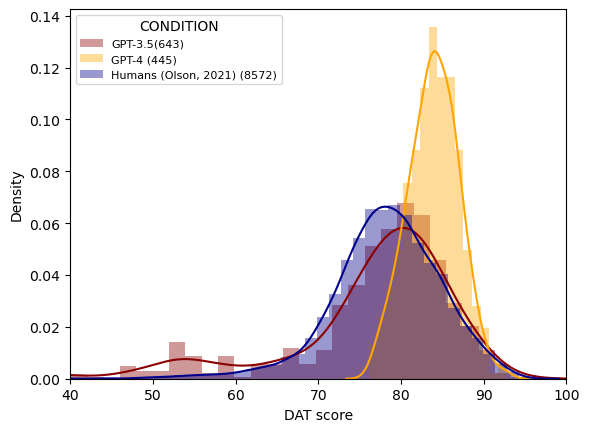

In [17]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
#print(np.mean(DAT_GPT))
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(DAT_GPT, label='GPT-3.5({})'.format(len(DAT_GPT)), color='darkred')
sbn.distplot(DAT_GPT4, label='GPT-4 ({})'.format(len(DAT_GPT4)), color='orange')
#sbn.distplot(DAT_bigdata, label='Humans ({})'.format(len(DAT_bigdata)), color='darkcyan')
sbn.distplot(dat_list, label='Humans (Olson, 2021) ({})'.format(len(dat_list)), color='darkblue')

mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#lt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')
plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'CONDITION', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT3-4_humans_olson_study.png', dpi=300)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18928\2404831850.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(DAT_GPT, label='None ({})'.format(len(DAT_GPT)), color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18928\2404831850.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplo

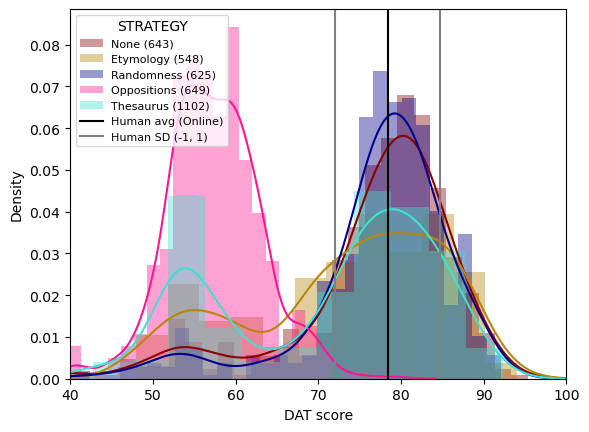

In [12]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
#print(np.mean(DAT_GPT))
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(DAT_GPT, label='None ({})'.format(len(DAT_GPT)), color='darkred')
sbn.distplot(DAT_GPT_ethym, label='Etymology ({})'.format(len(DAT_GPT_ethym)), color='darkgoldenrod')
sbn.distplot(DAT_GPT_rnd, label='Randomness ({})'.format(len(DAT_GPT_rnd)), color='darkblue')
sbn.distplot(DAT_GPT_opp, label='Oppositions ({})'.format(len(DAT_GPT_opp)), color='deeppink')
sbn.distplot(DAT_GPT_thes, label='Thesaurus ({})'.format(len(DAT_GPT_thes)), color='turquoise')
#sbn.distplot(GPT_raw, label='No-DAT ({})'.format(len(GPT_raw)), color='orange')


mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
plt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
plt.axvline(x = 72.03, color = 'grey')
plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'STRATEGY', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT_humans5.png', dpi=300)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\1702088327.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(DAT_GPT4, label='None ({})'.format(len(DAT_GPT4)), color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18048\1702088327.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distp

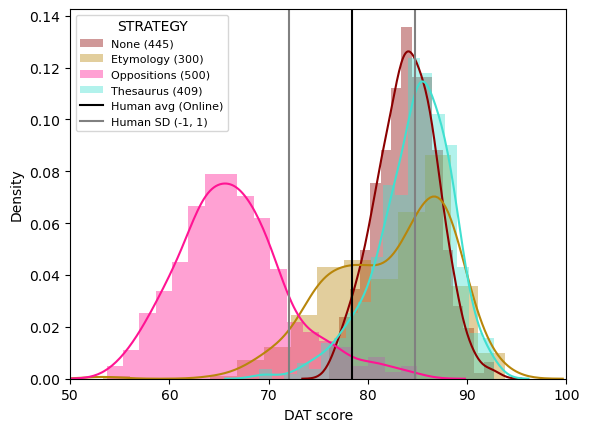

In [40]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
#print(np.mean(DAT_GPT))
DAT_GPT  = [i for i in DAT_GPT if i is not None]
DAT_GPT_ethym = [i for i in DAT_GPT_ethym if i is not None]
DAT_GPT_rnd = [i for i in DAT_GPT_rnd if i is not None]
DAT_GPT_thes = [i for i in DAT_GPT_thes if i is not None]
DAT_GPT_opp = [i for i in DAT_GPT_opp if i is not None]
sbn.distplot(DAT_GPT4, label='None ({})'.format(len(DAT_GPT4)), color='darkred')
sbn.distplot(GPT4_ethym, label='Etymology ({})'.format(len(GPT4_ethym)), color='darkgoldenrod')
#sbn.distplot(DAT_GPT_rnd, label='Randomness ({})'.format(len(DAT_GPT_rnd)), color='darkblue')
sbn.distplot(GPT4_opp, label='Oppositions ({})'.format(len(GPT4_opp)), color='deeppink')
sbn.distplot(GPT4_thes, label='Thesaurus ({})'.format(len(GPT4_thes)), color='turquoise')
#sbn.distplot(GPT_raw, label='No-DAT ({})'.format(len(GPT_raw)), color='orange')


mu = 78.38
sigma = 6.35
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
plt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
plt.axvline(x = 72.03, color = 'grey')
plt.xlim((50, 100))
plt.xlabel('DAT score')
plt.legend(title = 'STRATEGY', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT4_strategies.png', dpi=300)

In [43]:
from scipy import stats

GPT4_thes = [x for x in GPT4_thes if str(x) != 'None']
GPT4_ethym = [x for x in GPT4_ethym if str(x) != 'None']
#GPT4_control_lowtemp = [x for x in GPT4_control_lowtemp if str(x) != 'None']
stats.ttest_ind(DAT_GPT4, GPT4_thes)

Ttest_indResult(statistic=-3.0650560351503953, pvalue=0.00224490143516167)

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18212\2965993242.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(DAT_GPT, label='Chat-GPT ({})'.format(len(DAT_GPT)), color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18212\2965993242.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.dist

78.1930193595094


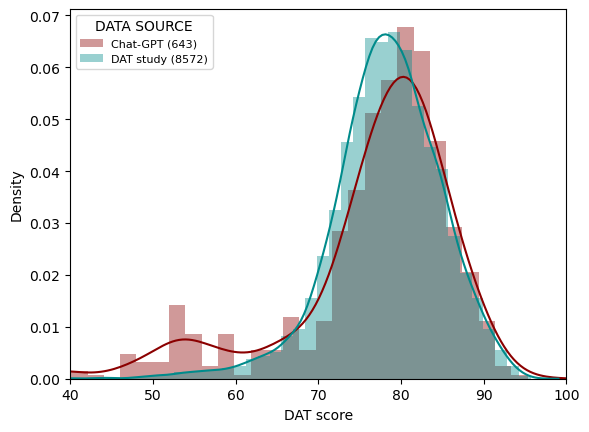

In [25]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

sbn.distplot(DAT_GPT, label='Chat-GPT ({})'.format(len(DAT_GPT)), color='darkred')
sbn.distplot(dat_list, label='DAT study ({})'.format(len(dat_list)), color='darkcyan')
pval, tval = stats.ttest_ind(dat_list, DAT_GPT)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#plt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')

mu_dat = np.mean(dat_list)
mu_gpt = np.mean(DAT_GPT)
sigma_dat = np.std(dat_list)
sigma_gpt = np.std(DAT_GPT)
n_dat = len(dat_list)
n_gpt = len(DAT_GPT)
df_dat = n_dat - 1
df_gpt = n_gpt - 1
se_dat = sigma_dat / math.sqrt(n_dat)
se_gpt = sigma_gpt / math.sqrt(n_gpt)
se_pool = math.sqrt(((df_dat * sigma_dat ** 2) + (df_gpt * sigma_gpt ** 2)) / (df_dat + df_gpt))
t_crit = stats.t.ppf(q=0.975, df=df_dat + df_gpt)
lower_dat = mu_dat - t_crit * se_pool
upper_dat = mu_dat + t_crit * se_pool
lower_gpt = mu_gpt - t_crit * se_pool
upper_gpt = mu_gpt + t_crit * se_pool
print(mu_dat)
if pval < 0.001:
    plt.plot([mu_dat, mu_gpt], [0.06, 0.06], linewidth=2, color='black')
    plt.text((mu_dat + mu_gpt) / 2, 2.8, "***", ha='center', va='center', fontsize=10)
elif pval < 0.01:
    plt.plot([mu_dat, mu_gpt], [2.5, 2.5], linewidth=2, color='black')
    plt.text((mu_dat + mu_gpt) / 2, 2.8, "**", ha='center', va='center', fontsize=10)
elif pval < 0.05:
    plt.plot([mu_dat, mu_gpt], [2.5, 2.5], linewidth=2, color='black')
    plt.text((mu_dat + mu_gpt) / 2, 2.8, "*", ha='center', va='center', fontsize=10)

plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'DATA SOURCE', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT_Olson.png', dpi=300)

0         68.084195
1         84.086075
2         87.142895
3         92.513970
4         60.442278
            ...    
745428    71.982275
745429    84.689421
745430    74.859983
745431    74.514039
745432    77.471465
Name: score, Length: 745433, dtype: float64

C:\Users\Antoine\AppData\Local\Temp\ipykernel_18212\1601815797.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(DAT_GPT, label='Chat-GPT ({})'.format(len(DAT_GPT)), color='darkred')
C:\Users\Antoine\AppData\Local\Temp\ipykernel_18212\1601815797.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.dist

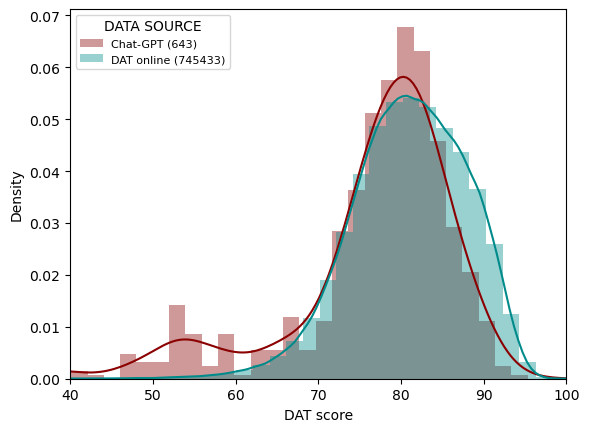

In [30]:
import seaborn as sbn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

sbn.distplot(DAT_GPT, label='Chat-GPT ({})'.format(len(DAT_GPT)), color='darkred')
sbn.distplot(DAT_bigdata, label='DAT online ({})'.format(len(DAT_bigdata)), color='darkcyan')
pval, tval = stats.ttest_ind(DAT_bigdata, DAT_GPT)
#plt.plot(x, stats.norm.pdf(x, mu, sigma))
#plt.axvline(x = np.mean(DAT_GPT), color = 'darkred', label = 'chat-GPT average')
#plt.axvline(x = 78.38, color = 'black', label = 'Human avg (Online)')
#plt.axvline(x = 84.73, color = 'grey', label = 'Human SD (-1, 1)')
#plt.axvline(x = 72.03, color = 'grey')


plt.xlim((40, 100))
plt.xlabel('DAT score')
plt.legend(title = 'DATA SOURCE', fontsize=8, loc='upper left')
plt.savefig('DAT_chat-GPT_Olson_bigdata.png', dpi=300)

In [32]:
tval

2.7688110811316767e-59

C:\Users\Antoine\AppData\Local\Temp\ipykernel_19088\2504257292.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(lists)


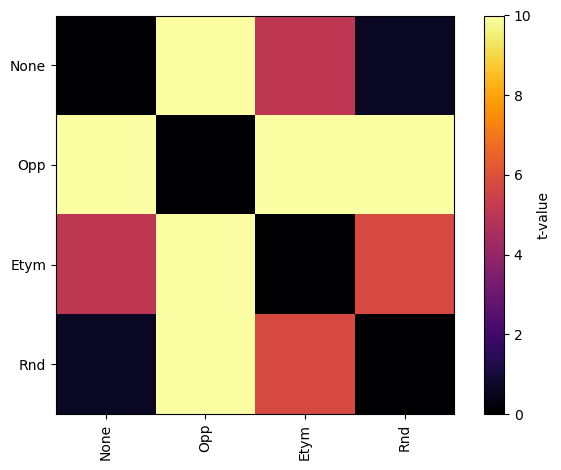

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.colors import LogNorm

def heatmap_t_values(lists, labels):
    # Convert the input lists into a 2D numpy array
    arr = np.array(lists)
    
    # Compute the t values
    t_values = np.zeros((arr.shape[0], arr.shape[0]))
    p_values = np.zeros((arr.shape[0], arr.shape[0]))
    for i in range(arr.shape[0]):
        for j in range(i+1, arr.shape[0]):
            t, p = stats.ttest_ind(arr[i], arr[j])
            t_values[i, j] = t
            t_values[j, i] = t
            p_values[i, j] = p
            p_values[j, i] = p
    
    # Plot the heatmap
    plt.imshow(np.abs(t_values), cmap='inferno', interpolation='nearest')
    plt.colorbar(label='t-value')
    plt.clim(0, 10)
    plt.xticks(np.arange(arr.shape[0]), labels, rotation=90)
    plt.yticks(np.arange(arr.shape[0]), labels)
    plt.tight_layout()
    #plt.show()
    plt.savefig('ttest_matrix2.png', dpi=300)
    return t_values, p_values

# Example usage
all_data = [DAT_GPT, DAT_GPT_opp, DAT_GPT_ethym, DAT_GPT_rnd]
labels = ['None', 'Opp', 'Etym', 'Rnd']
t_vals = heatmap_t_values(all_data, labels)



In [10]:
t_vals[1]

array([[0.00000000e+000, 2.11890675e-234, 5.30492593e-007,
        5.09715549e-001],
       [2.11890675e-234, 0.00000000e+000, 6.80712446e-150,
        1.73792906e-253],
       [5.30492593e-007, 6.80712446e-150, 0.00000000e+000,
        1.18303383e-008],
       [5.09715549e-001, 1.73792906e-253, 1.18303383e-008,
        0.00000000e+000]])